In [1]:
import json
import os

depth = 2
directory_path = f'./airflow/cleaned_data_{depth}'
data = []

for file in os.scandir(directory_path):
    try:
        with open(file.path, 'r') as f: 
            data.extend(json.load(f))

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

In [2]:
og_len = len(data)
og_len

164919

In [3]:
import pandas as pd

data = pd.DataFrame(data)
data = data.sort_values(by='layer', ascending=True)
data


,title,sub_title,text,category,layer
164918,Young subgroup,None,"Inmathematics, theYoung subgroupsof thesymmetr...",Combinatorics,1
48064,P-adic number,Example,Let us compute the 5-adic expansion of\tfrac 1...,Number theory,1
48065,P-adic number,''p''-adic integers,The-adic integersare the-adic numbers with a n...,Number theory,1
48066,P-adic number,Topological properties,The-adic valuation allows defining anabsolute ...,Number theory,1
48067,P-adic number,Modular properties,Thequotient ring\Z_p/p^n\Z_pmay be identified ...,Number theory,1
...,...,...,...,...,...
60012,Filter bank,Filter-bank design in the frequency domain,"When perfect reconstruction is not needed, the...",Numerical analysis,2
60013,Filter bank,Direct frequency-domain optimization,Many of the existing methods for designing 2-c...,Numerical analysis,2
60014,Filter bank,Directional filter banks,Bamberger and Smith proposed a 2D directional ...,Numerical analysis,2
60016,Fast wavelet transform,None,Thefast wavelet transformis amathematicalalgor...,Numerical analysis,2


In [4]:
data = data.drop_duplicates(subset=['category', 'text'])
print(f'{len(data)/og_len:.2%} of df remained')

86.29% of df remained


In [5]:
df_counts = data["category"].value_counts()
df_counts.to_frame().T

category,Applied mathematics,Mathematical logic,Dynamical systems,Numerical analysis,Combinatorics,Linear algebra,Topology,Analysis,Number theory,Algebra,...,Set theory,Order theory,Trigonometry,Chaos theory,Fractals,Statistics,Model theory,Linear programming,Multi-dimensional geometry,Probability and statistics
count,15612,8993,8605,8447,8376,7477,7394,7244,7188,6764,...,2435,1933,1564,1449,1329,1067,914,902,898,117


In [6]:
data.loc[data['category'] == 'Probability and statistics', 'category'] = 'Statistics'
df_counts = data["category"].value_counts()
df_counts.to_frame().T

/tmp/ipykernel_12356/1238885651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['category'] == 'Probability and statistics', 'category'] = 'Statistics'


category,Applied mathematics,Mathematical logic,Dynamical systems,Numerical analysis,Combinatorics,Linear algebra,Topology,Analysis,Number theory,Algebra,...,Calculus,Set theory,Order theory,Trigonometry,Chaos theory,Fractals,Statistics,Model theory,Linear programming,Multi-dimensional geometry
count,15612,8993,8605,8447,8376,7477,7394,7244,7188,6764,...,3254,2435,1933,1564,1449,1329,1184,914,902,898


In [7]:
all_labels = list(data['category'].unique())
all_labels

['Combinatorics',
 'Number theory',
 'Geometry',
 'Dynamical systems',
 'Linear algebra',
 'Graph theory',
 'Model theory',
 'Analysis',
 'Group theory',
 'Applied mathematics',
 'Statistics',
 'Trigonometry',
 'Calculus',
 'Category theory',
 'Algebraic geometry',
 'Complex analysis',
 'Algebra',
 'Mathematical logic',
 'Fractals',
 'Numerical analysis',
 'Set theory',
 'Multi-dimensional geometry',
 'Game theory',
 'Algebraic topology',
 'Arithmetic',
 'Linear programming',
 'Chaos theory',
 'Order theory',
 'Topology']

In [8]:
data = data.groupby("text").agg({
    "category": lambda x: list(set(x)),  # collect unique categories
    "title": "first",
    "sub_title": "first"}).reset_index()

data

,text,category,title,sub_title
0,,[Algebraic topology],Template:Infobox knot theory,None
1,,[Numerical analysis],Verlet integration,Literature
2,"\nIncorrect code, p[i] is overwritten used in...",[Applied mathematics],Binomial options pricing model,Method
3,0 1 2 3 4 5 6 7 8 9 sum 1 0 1 1 2 1...,"[Dynamical systems, Combinatorics, Topology, G...",Cycles and fixed points,Some values
4,Primorial prime?- 0 1 1 1 1 2 2 2 ...,"[Combinatorics, Number theory]",Primorial,Table of primorials
...,...,...,...,...
100485,"“The farthest planet from the sun”, as it appe...",[Mathematical logic],Frege–Church ontology,Resolution
100486,•Length.The length is the number of evaluation...,[Applied mathematics],Locally recoverable code,Parameters of Tamo–Barg codes
100487,"″On the Nature of Mathematical Truth""and ""Geom...",[Mathematical logic],Carl Gustav Hempel,Articles
100488,将棋ぶらうざQ (Shogi Browser Q) is a free cross-plat...,[Game theory],Computer shogi,Shogi Browser Q


In [9]:
data['length'] = data['text'].apply(lambda x: len(x.split()))
data.describe(include='all')

,text,category,title,sub_title,length
count,100490,100490,100490,89409,100490.000000
unique,100490,822,20614,54613,NaN
top,꜔(U+A714) Modifier Letter Mid Left-Stem Tone B...,[Applied mathematics],List of fellows of the American Statistical As...,Introduction,NaN
freq,1,10817,108,9516,NaN
mean,NaN,NaN,NaN,NaN,179.383282
std,NaN,NaN,NaN,NaN,199.509129
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,69.000000
50%,NaN,NaN,NaN,NaN,132.000000
75%,NaN,NaN,NaN,NaN,235.000000


In [10]:
percentiles = data['length'].quantile([0.5, 0.9, 0.95, 0.99])
percentiles

0.50    132.0
0.90    372.0
0.95    469.0
0.99    785.0
Name: length, dtype: float64

In [11]:
data = data[data['length'] <= percentiles[0.95]]
data = data[data['length'] >= 10]
print(f'{len(data)/og_len:.2%} of df remained')
data.describe(include='all')

56.92% of df remained


,text,category,title,sub_title,length
count,93868,93868,93868,83667,93868.000000
unique,93868,787,19667,51274,NaN
top,꜔(U+A714) Modifier Letter Mid Left-Stem Tone B...,[Applied mathematics],List of fellows of the American Statistical As...,Introduction,NaN
freq,1,10027,93,9278,NaN
mean,NaN,NaN,NaN,NaN,154.154781
std,NaN,NaN,NaN,NaN,107.677579
min,NaN,NaN,NaN,NaN,10.000000
25%,NaN,NaN,NaN,NaN,69.000000
50%,NaN,NaN,NaN,NaN,127.000000
75%,NaN,NaN,NaN,NaN,217.000000


In [12]:
data["category"].apply(lambda x : len(x)).value_counts().to_frame().T

category,1,2,3,4,5,6,7
count,64637,21991,5177,1591,343,120,9


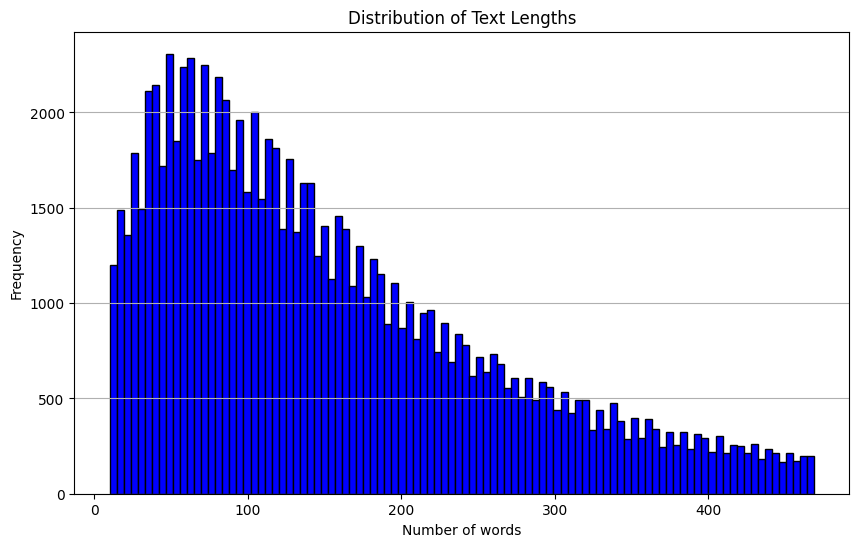

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["Algebra", "Calculus"], ["Game theory"]])

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [15]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["category"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:,0]], df.iloc[ind_test[:,0]]

In [16]:
np.random.seed(42)
train_df, temp_df = balanced_split(data, test_size=0.4)
valid_df, test_df = balanced_split(temp_df, test_size=0.5)

In [17]:
for df in [train_df, valid_df, test_df]:
    df.drop(columns=['length'], inplace=True)

/tmp/ipykernel_12356/432034294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['length'], inplace=True)
/tmp/ipykernel_12356/432034294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['length'], inplace=True)
/tmp/ipykernel_12356/432034294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['length'], inplace=True)


In [18]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
valid_ds = Dataset.from_pandas(valid_df, preserve_index=False)
test_ds = Dataset.from_pandas(test_df, preserve_index=False)

ds = DatasetDict({
    'train': train_ds,
    'valid': valid_ds,
    'test': test_ds
})

In [19]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'title', 'sub_title'],
        num_rows: 56379
    })
    valid: Dataset({
        features: ['text', 'category', 'title', 'sub_title'],
        num_rows: 18699
    })
    test: Dataset({
        features: ['text', 'category', 'title', 'sub_title'],
        num_rows: 18790
    })
})

In [20]:
from huggingface_hub import login

login()

In [21]:
repo_id = "noor-zalouk/wiki-math-articles-multilabel"
ds.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/57 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  525kB / 38.3MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/19 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         |  525kB / 12.9MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/19 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         |  525kB / 12.9MB            

CommitInfo(commit_url='https://huggingface.co/datasets/noor-zalouk/wiki-math-articles-multilabel/commit/1e8d4e731658b6bd33d74b5b0a645fab808c06b9', commit_message='Upload dataset', commit_description='', oid='1e8d4e731658b6bd33d74b5b0a645fab808c06b9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/noor-zalouk/wiki-math-articles-multilabel', endpoint='https://huggingface.co', repo_type='dataset', repo_id='noor-zalouk/wiki-math-articles-multilabel'), pr_revision=None, pr_num=None)